In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
figsize(15, 9)
import scipy.stats as stats
import behavioral_models
plt.style.use('ggplot')
import pymc as pm
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import pandas as pd
import supportfun
from datetime import datetime, date, time


/Users/Xin/anaconda/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/Xin/anaconda/envs/py27/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# connect to database
user = 'Xin' #add your username here (same as previous postgreSQL)                      
host = 'localhost'
dbname = 'spire_user'
con = None
con = psycopg2.connect(database = dbname, user = user)

In [3]:
# load user data from database
userid = 5
# query
sql_query = "SELECT * FROM user_data as ud INNER JOIN user_id as ui ON ud.md5 = ui.md5 WHERE ui.index = %i;" %(userid)
data_from_sql = pd.read_sql_query(sql_query,con)

In [7]:
df_short = data_from_sql.iloc[:,[0, 2, 5, 6, 8, 9, 10, 11, 12, -3, -5, -6, -7]]

In [8]:
hour = supportfun.hours(df_short)
df_short["hours"] = hour

/Users/Xin/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [9]:
#df_short_cut = df_short[df_short.streak_type != "inactive"]
df_short_cut = df_short
df_short_cut.streak_type = df_short.streak_type.astype(float)
df_tmp = df_short_cut.groupby(["start_ymd","hours","streak_type", "time_len"])
df_freq = df_tmp.sum()
df_freq = df_freq.reset_index()
df_tmp1 = df_freq.groupby(["start_ymd","hours","streak_type"]).sum()
df_freq = df_tmp1.reset_index()
df_freq = df_freq.iloc[:, [0, 1, 2, 3]]
year = {}
month = {}
day = {}
weekday = {}
for i in range(len(df_freq.start_ymd)):
    dt = datetime.strptime(df_freq.start_ymd[i], "%Y-%m-%d")
    year[i] = dt.year
    month[i] = dt.month
    day[i] = dt.day
    weekday[i] = dt.weekday()
df_freq['year'] = year.values()
df_freq['month'] = month.values()
df_freq['day'] = day.values()
df_freq['weekday'] = weekday.values() # monday is 0, sunday is 6

In [10]:
df_daily = df_freq.groupby(["start_ymd", "streak_type"]).sum().reset_index()

In [11]:
g11 = df_daily[df_daily.streak_type == 0]
g22 = df_daily[df_daily.streak_type == 1]
g33 = df_daily[df_daily.streak_type == 2]
np1 = []
np2 = []
np3 = []
for i in range(len(g11.streak_type)):
    np1.append(np.datetime64(g11.start_ymd.iloc[i]))
for i in range(len(g22.streak_type)):
    np2.append(np.datetime64(g22.start_ymd.iloc[i]))
for i in range(len(g33.streak_type)):
    np3.append(np.datetime64(g33.start_ymd.iloc[i]))
min_count1 = (g11.time_len/60).astype(int) # minute counts of calm
min_count2 = (g22.time_len/60).astype(int) # minute counts of focus
min_count3 = (g33.time_len/60).astype(int) # minute counts of tense

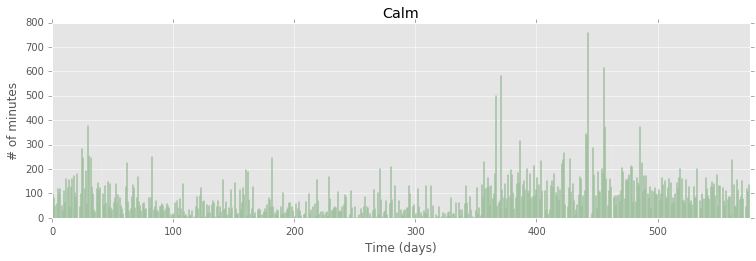

In [13]:
count_data1 = supportfun.data_explore(min_count1, "#006400", "# of minutes", "Calm")
n_count_data1 = len(count_data1)

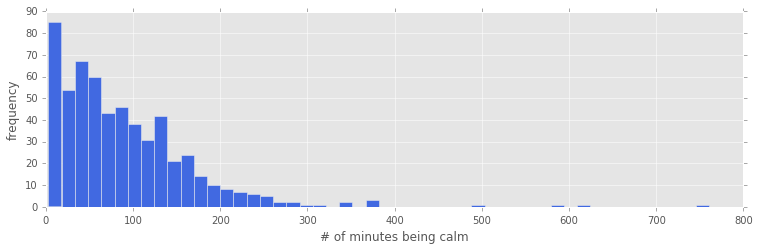

In [14]:
plt.hist(count_data1, bins = 50, color = "#4169e1")
plt.xlabel("# of minutes being calm")
plt.ylabel("frequency")
plt.show()

In [15]:
mcmcrun1 = supportfun.runmcmc(count_data1, 40000, 30000)

('Random output:', array(87), array(230), array(133))
 [-----------------100%-----------------] 40000 of 40000 complete in 11.0 sec

In [16]:
lambda_1_samples = mcmcrun1.trace('lambda_1')[:]
lambda_2_samples = mcmcrun1.trace('lambda_2')[:]
tau_samples = mcmcrun1.trace('tau')[:]
mcmcrun1.logp #-15074.988677177333

-15077.182234323906

In [33]:
tau_samples

array([354, 354, 354, ..., 354, 354, 354])

Plotting lambda_1
Plotting tau
Plotting lambda_2


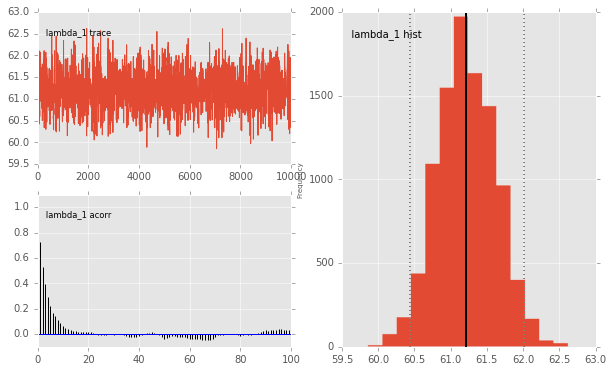

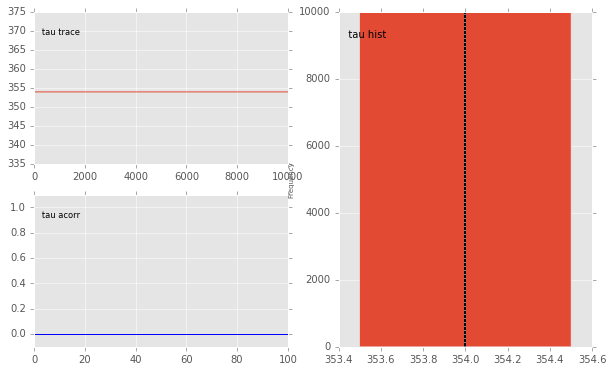

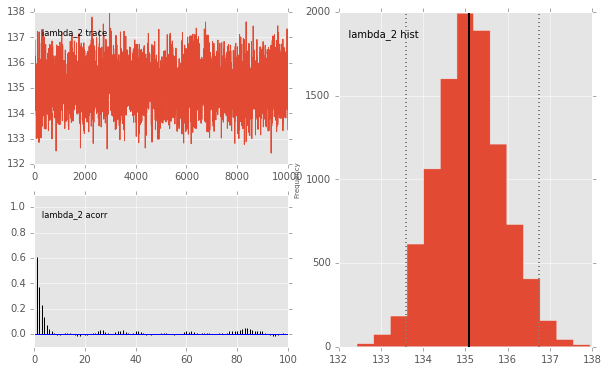

In [17]:
pm.Matplot.plot(mcmcrun1)

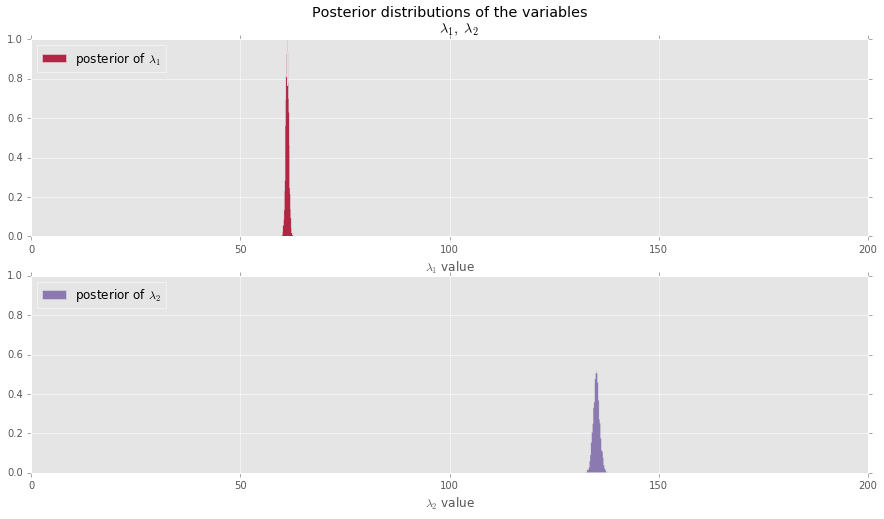

In [23]:
figsize(15, 12)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2$""")
plt.xlim([0, 200])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([0, 200])
plt.xlabel("$\lambda_2$ value")

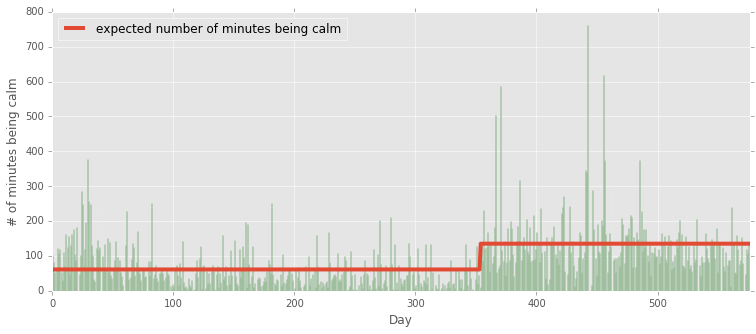

In [24]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data1)
for day in range(0, n_count_data1):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data1), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of minutes being calm")
plt.xlim(0, n_count_data1)
plt.xlabel("Day")
plt.ylabel("# of minutes being calm")
#plt.title("Expected number of minutes being calm")
plt.ylim(0, 800)
plt.bar(np.arange(len(count_data1)), count_data1, color="#006400", alpha=0.65)

plt.legend(loc="upper left");

In [35]:
mcmcrun11 = supportfun.runmcmc2(count_data1, 40000, 30000)

 [-----------------100%-----------------] 40000 of 40000 complete in 18.3 sec

In [36]:
lambda_1_samples = mcmcrun11.trace('lambda_1')[:]
lambda_2_samples = mcmcrun11.trace('lambda_2')[:]
lambda_3_samples = mcmcrun11.trace('lambda_3')[:]
tau1_samples = mcmcrun11.trace('tau_1')[:]
tau2_samples = mcmcrun11.trace('tau_2')[:]
mcmcrun11.logp #-13378.432238488587

-13378.566759417638

Plotting tau_1
Plotting lambda_2
Plotting lambda_1
Plotting lambda_3
Plotting tau_2


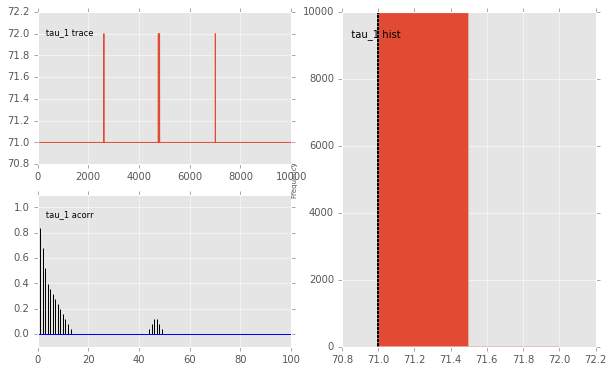

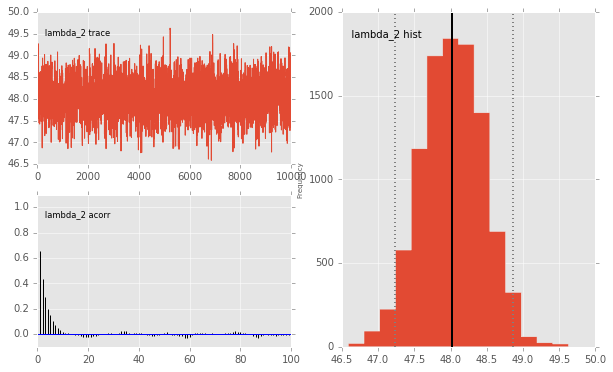

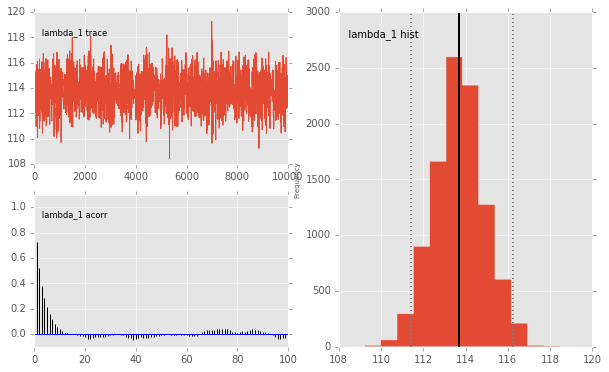

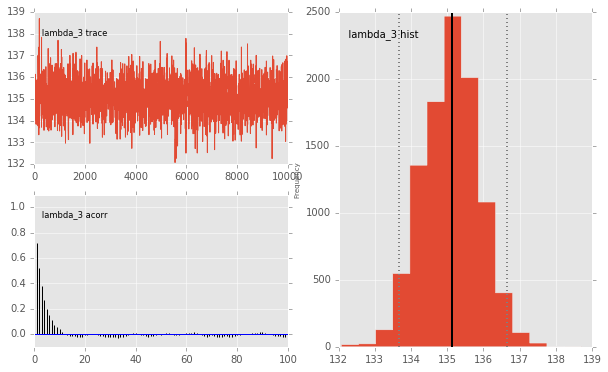

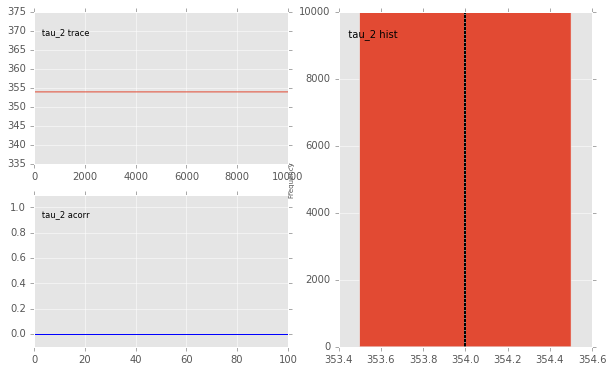

In [37]:
pm.Matplot.plot(mcmcrun11)

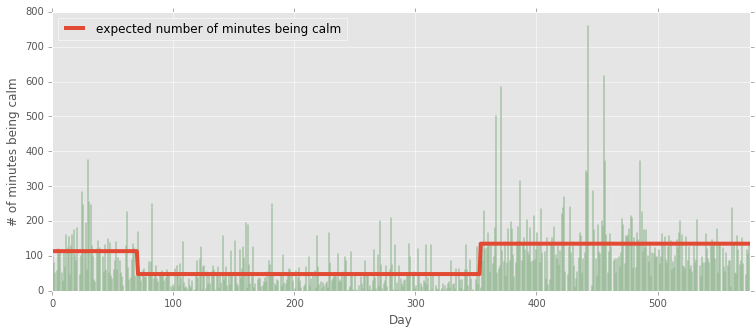

In [38]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau1_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data1)
for day in range(0, n_count_data1):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau1_samples   
    iix = tau1_samples <= day 
    tmp = day < tau2_samples
    for i in range(len(iix)):
        if not tmp[i]:
            iix[i] = False
    iiix = tau2_samples <= day
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[iix].sum() + lambda_3_samples[iiix].sum()) / N


plt.plot(range(n_count_data1), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of minutes being calm")
plt.xlim(0, n_count_data1)
plt.xlabel("Day")
plt.ylabel("# of minutes being calm")
#plt.title("Expected number of minutes being calm")
plt.ylim(0, 800)
plt.bar(np.arange(len(count_data1)), count_data1, color="#006400", alpha=0.65)

plt.legend(loc="upper left");

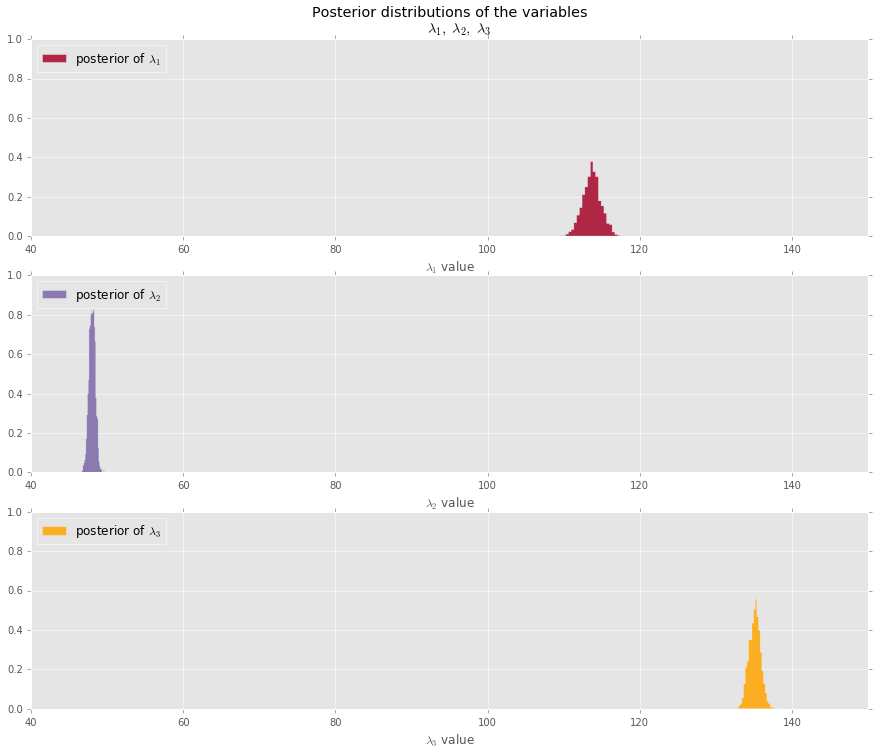

In [39]:
figsize(15, 12)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\lambda_3$""")
plt.xlim([40, 150])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([40, 150])
plt.xlabel("$\lambda_2$ value")

ax = plt.subplot(313)
ax.set_autoscaley_on(False)
plt.hist(lambda_3_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_3$", color="#ffa500", normed=True)
plt.legend(loc="upper left")
plt.xlim([40, 150])
plt.xlabel("$\lambda_3$ value")


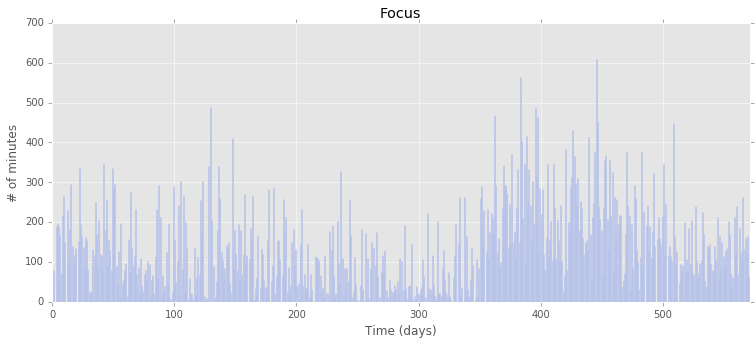

In [164]:
count_data2 = supportfun.data_explore(min_count2, "#4169e1", "# of minutes", "Focus")
n_count_data2 = len(count_data2)

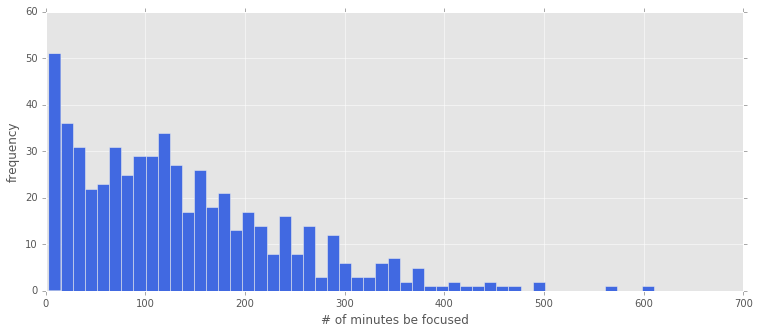

In [168]:
plt.hist(count_data2, bins = 50, color = "#4169e1")
plt.xlabel("# of minutes be focused")
plt.ylabel("frequency")
plt.show()

In [173]:
mcmcrun2 = supportfun.runmcmc(count_data2, 40000, 30000)

('Random output:', array(492), array(321), array(216))
 [-----------------100%-----------------] 40000 of 40000 complete in 11.2 sec

In [174]:
lambda_1_samples = mcmcrun2.trace('lambda_1')[:]
lambda_2_samples = mcmcrun2.trace('lambda_2')[:]
tau_samples = mcmcrun2.trace('tau')[:]
mcmcrun2.logp #--20802.847194981987

-20802.847194981987

Plotting lambda_2
Plotting lambda_1
Plotting tau


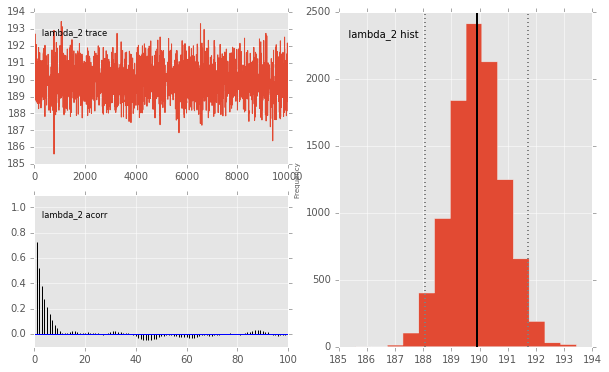

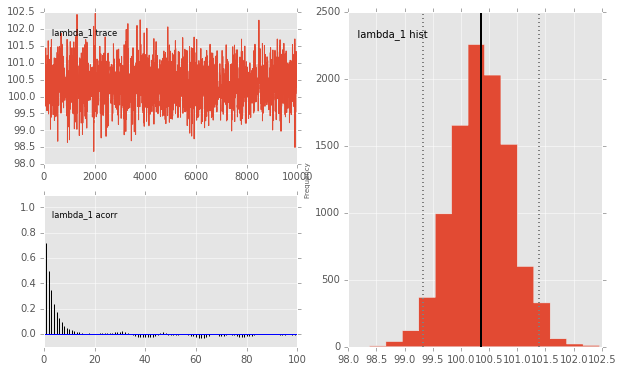

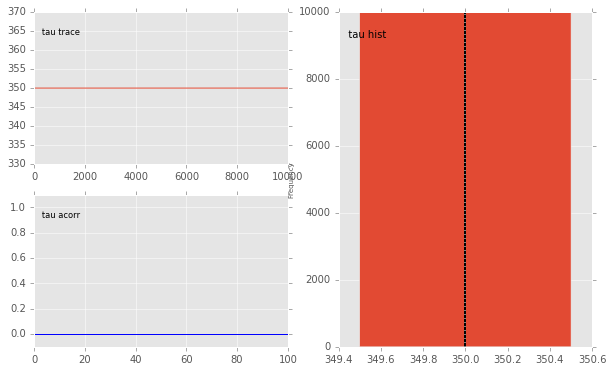

In [175]:
pm.Matplot.plot(mcmcrun2)

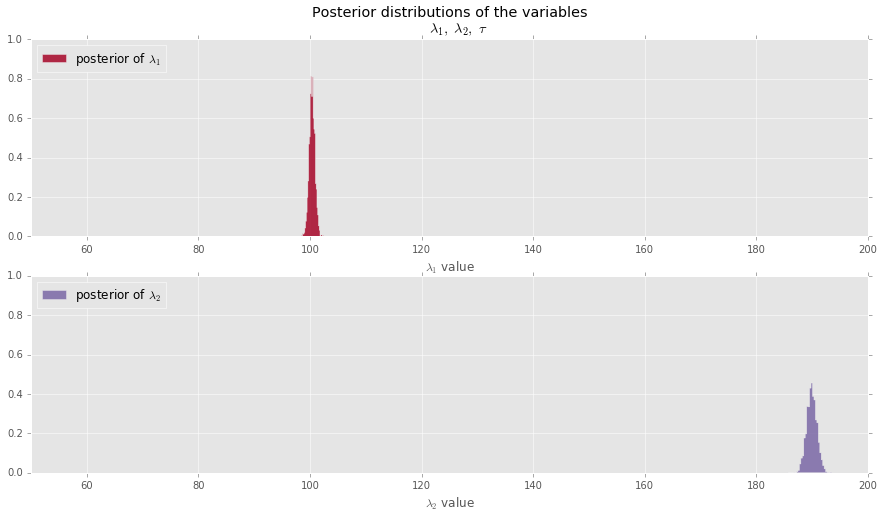

In [176]:
figsize(15, 12)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([50, 200])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([50, 200])
plt.xlabel("$\lambda_2$ value")

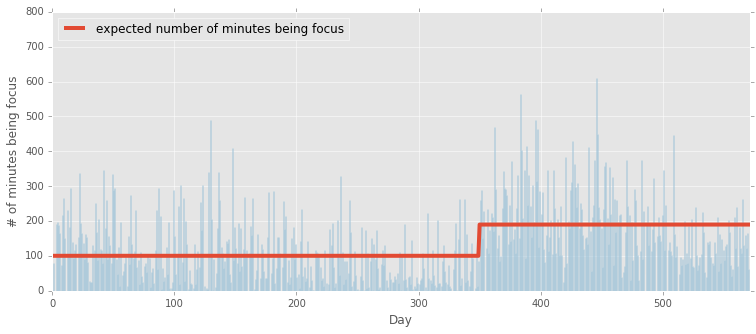

In [177]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data2)
for day in range(0, n_count_data2):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data2), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of minutes being focus")
plt.xlim(0, n_count_data2)
plt.xlabel("Day")
plt.ylabel("# of minutes being focus")
#plt.title("Expected number of minutes being calm")
plt.ylim(0, 800)
plt.bar(np.arange(len(count_data2)), count_data2, color="#348ABD", alpha=0.65)

plt.legend(loc="upper left");

In [197]:
mcmcrun22 = supportfun.runmcmc2(count_data2, 40000, 30000)

 [-----------------100%-----------------] 40000 of 40000 complete in 19.2 sec

In [198]:
lambda_1_samples = mcmcrun22.trace('lambda_1')[:]
lambda_2_samples = mcmcrun22.trace('lambda_2')[:]
lambda_3_samples = mcmcrun22.trace('lambda_3')[:]
tau1_samples = mcmcrun22.trace('tau_1')[:]
tau2_samples = mcmcrun22.trace('tau_2')[:]
mcmcrun22.logp #-19426.462361499707

-19744.90768159326

Plotting lambda_1
Plotting lambda_2
Plotting tau_1
Plotting tau_2
Plotting lambda_3


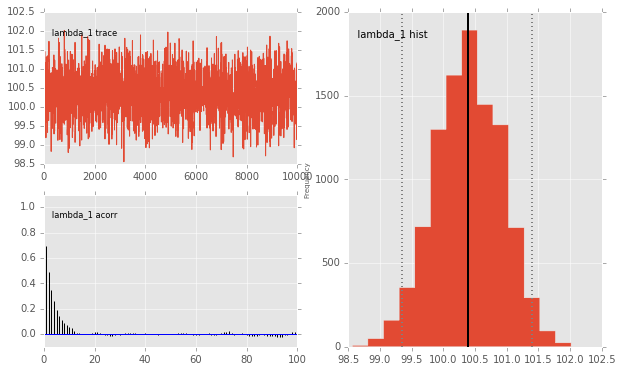

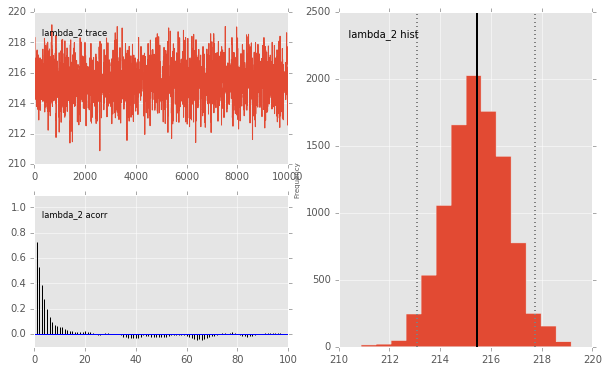

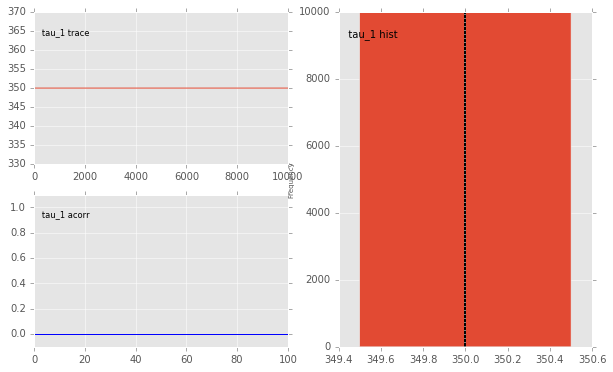

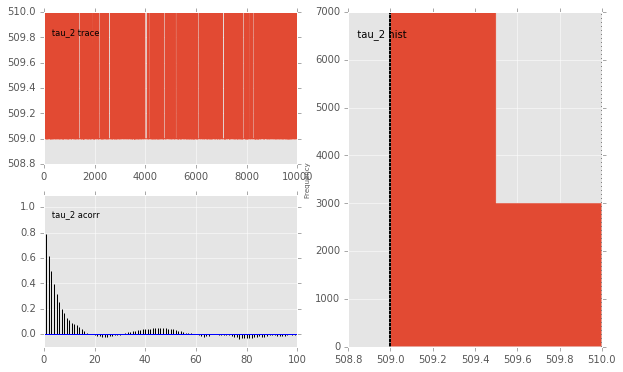

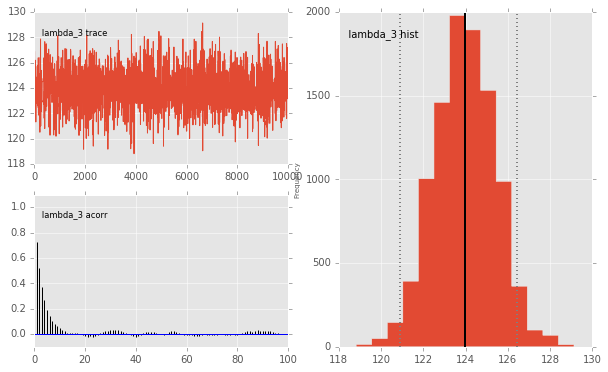

In [199]:
pm.Matplot.plot(mcmcrun22)

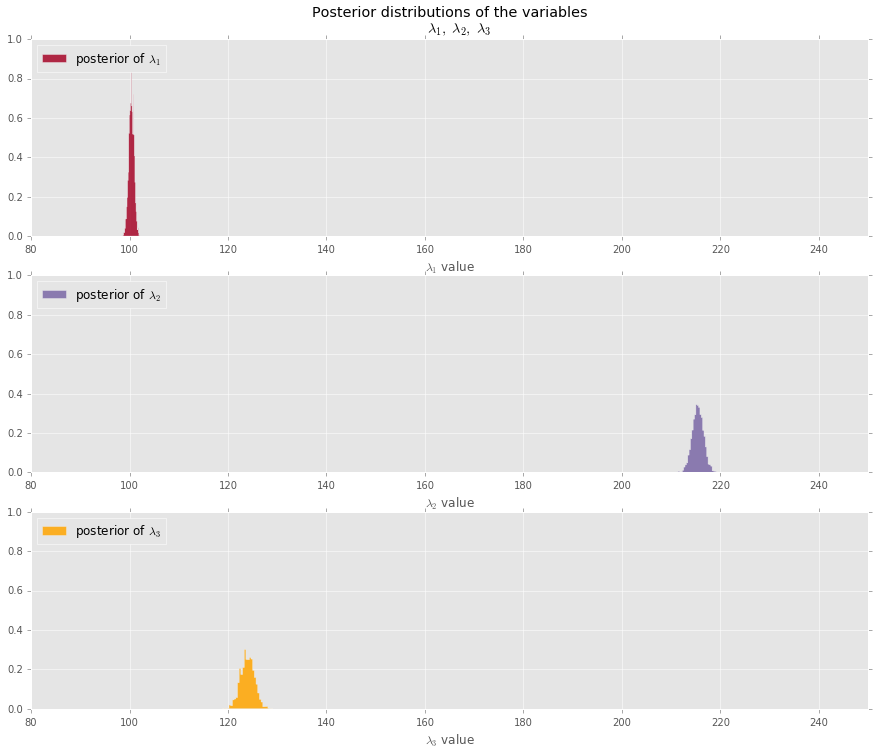

In [200]:
figsize(15, 12)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\lambda_3$""")
plt.xlim([80, 250])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([80, 250])
plt.xlabel("$\lambda_2$ value")

ax = plt.subplot(313)
ax.set_autoscaley_on(False)
plt.hist(lambda_3_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_3$", color="#ffa500", normed=True)
plt.legend(loc="upper left")
plt.xlim([80, 250])
plt.xlabel("$\lambda_3$ value")


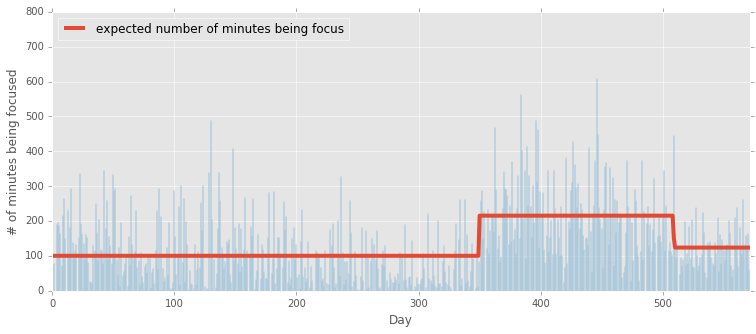

In [202]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau1_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data2)
for day in range(0, n_count_data2):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau1_samples   
    iix = tau1_samples <= day 
    tmp = day < tau2_samples
    for i in range(len(iix)):
        if not tmp[i]:
            iix[i] = False
    iiix = tau2_samples <= day
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[iix].sum() + lambda_3_samples[iiix].sum()) / N


plt.plot(range(n_count_data2), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of minutes being focus")
plt.xlim(0, n_count_data2)
plt.xlabel("Day")
plt.ylabel("# of minutes being focused")
#plt.title("Expected number of minutes being calm")
plt.ylim(0, 800)
plt.bar(np.arange(len(count_data2)), count_data2, color="#348ABD", alpha=0.65)

plt.legend(loc="upper left");

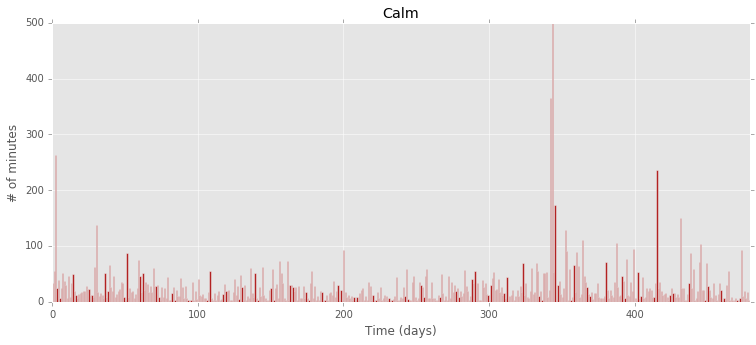

In [203]:
count_data3 = supportfun.data_explore(min_count3, "#b22222", "# of minutes", "Tense")
n_count_data3 = len(count_data3)

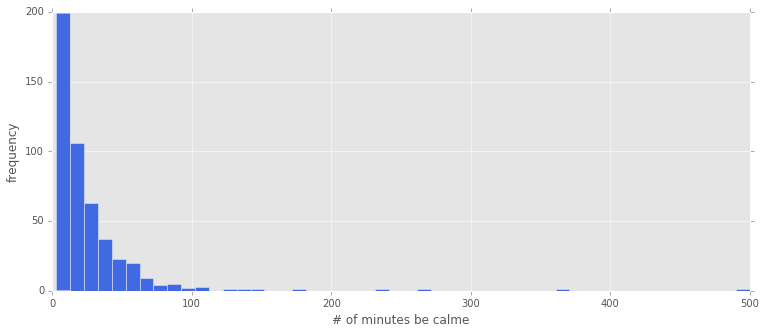

In [204]:
plt.hist(count_data3, bins = 50, color = "#4169e1")
plt.xlabel("# of minutes be calme")
plt.ylabel("frequency")
plt.show()

In [205]:
mcmcrun3 = supportfun.runmcmc(count_data3, 40000, 30000)

('Random output:', array(356), array(305), array(21))
 [-----------------100%-----------------] 40000 of 40000 complete in 8.4 sec

In [207]:
lambda_1_samples = mcmcrun3.trace('lambda_1')[:]
lambda_2_samples = mcmcrun3.trace('lambda_2')[:]
tau_samples = mcmcrun3.trace('tau')[:]
mcmcrun3.logp #-7518.999963873561

-7518.999963873561

Plotting lambda_1
Plotting lambda_2
Plotting tau


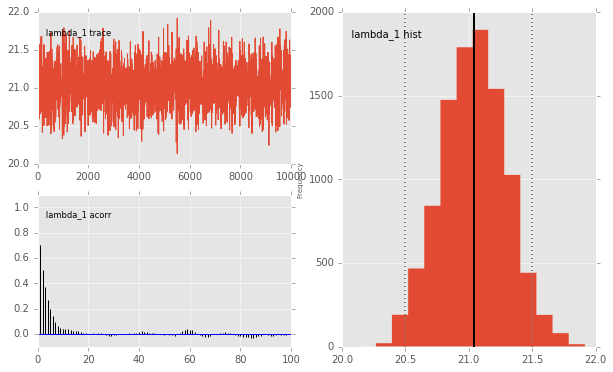

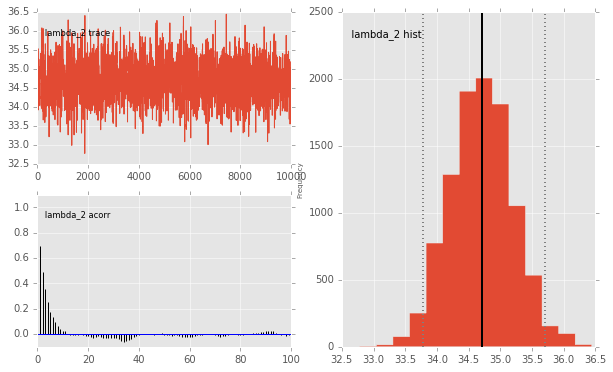

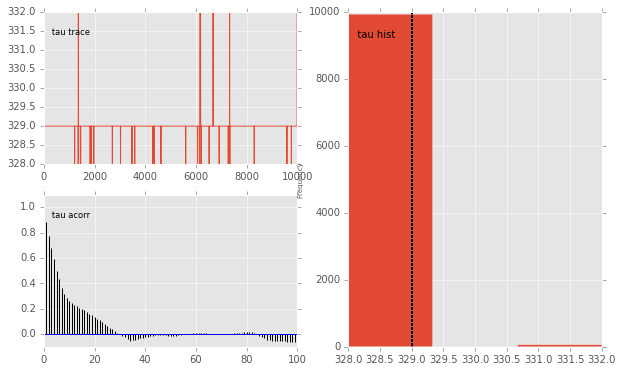

In [208]:
pm.Matplot.plot(mcmcrun3)

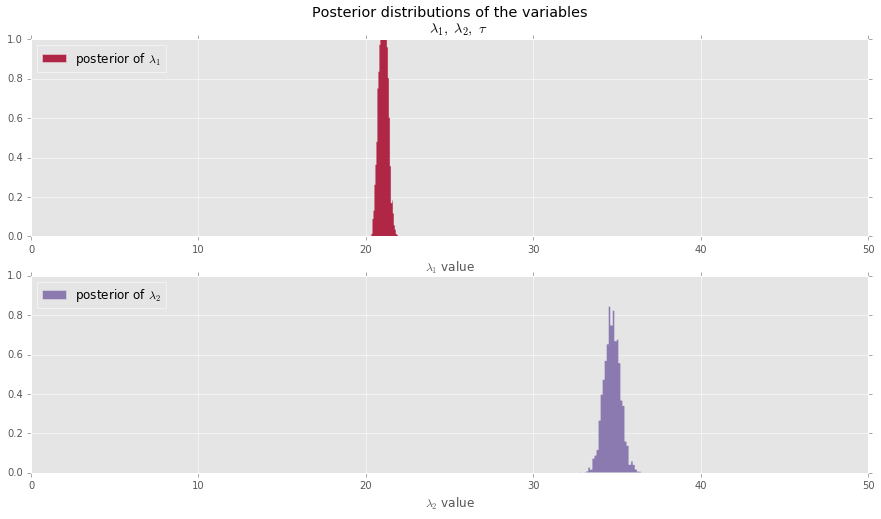

In [209]:
figsize(15, 12)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([0, 50])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([0, 50])
plt.xlabel("$\lambda_2$ value")

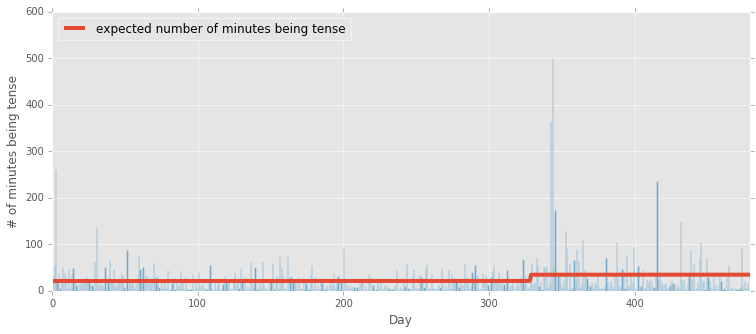

In [210]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data3)
for day in range(0, n_count_data3):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data3), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of minutes being tense")
plt.xlim(0, n_count_data3)
plt.xlabel("Day")
plt.ylabel("# of minutes being tense")
#plt.title("Expected number of minutes being calm")
plt.ylim(0, 600)
plt.bar(np.arange(len(count_data3)), count_data3, color="#348ABD", alpha=0.65)

plt.legend(loc="upper left");

In [211]:
mcmcrun33 = supportfun.runmcmc2(count_data3, 40000, 30000)

 [-----------------100%-----------------] 40000 of 40000 complete in 15.2 sec

In [212]:
lambda_1_samples = mcmcrun33.trace('lambda_1')[:]
lambda_2_samples = mcmcrun33.trace('lambda_2')[:]
lambda_3_samples = mcmcrun33.trace('lambda_3')[:]
tau1_samples = mcmcrun33.trace('tau_1')[:]
tau2_samples = mcmcrun33.trace('tau_2')[:]
mcmcrun33.logp #-13378.432238488587

-6175.183761548716

Plotting tau_2
Plotting lambda_3
Plotting lambda_1
Plotting tau_1
Plotting lambda_2


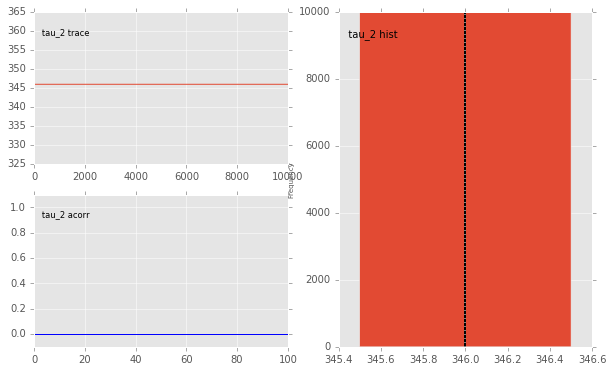

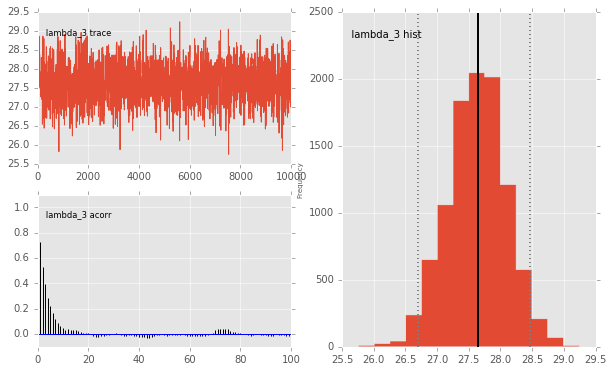

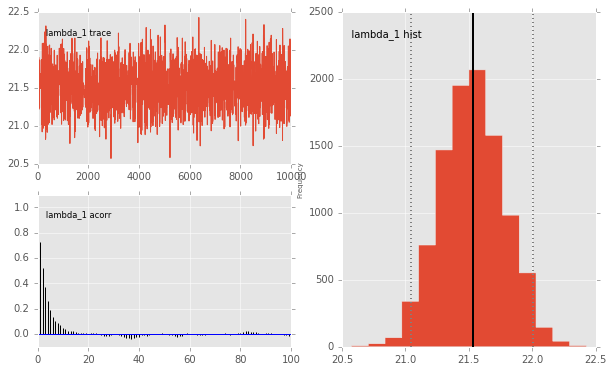

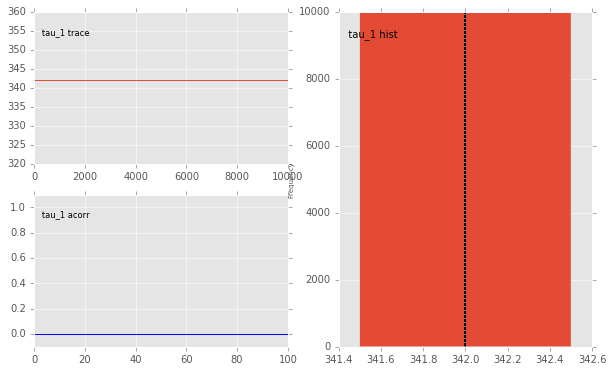

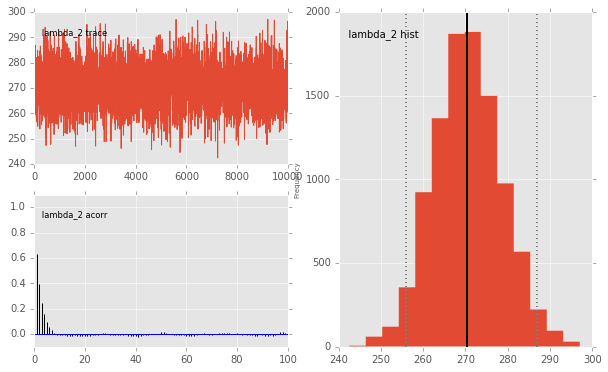

In [213]:
pm.Matplot.plot(mcmcrun33)

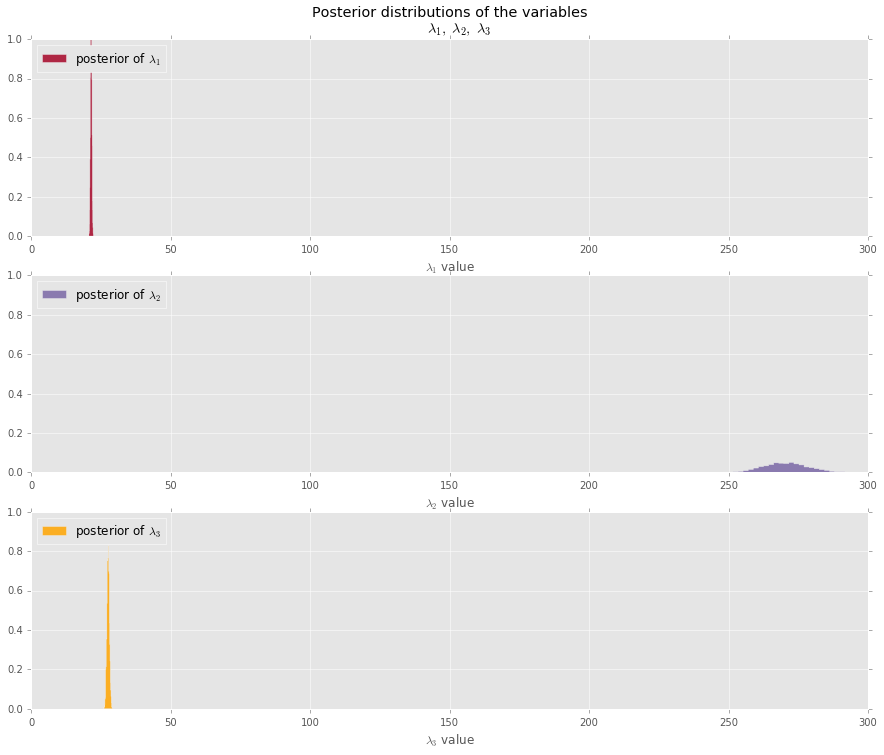

In [216]:
figsize(15, 12)
# histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\lambda_3$""")
plt.xlim([0, 300])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([0, 300])
plt.xlabel("$\lambda_2$ value")

ax = plt.subplot(313)
ax.set_autoscaley_on(False)
plt.hist(lambda_3_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_3$", color="#ffa500", normed=True)
plt.legend(loc="upper left")
plt.xlim([0, 300])
plt.xlabel("$\lambda_3$ value")


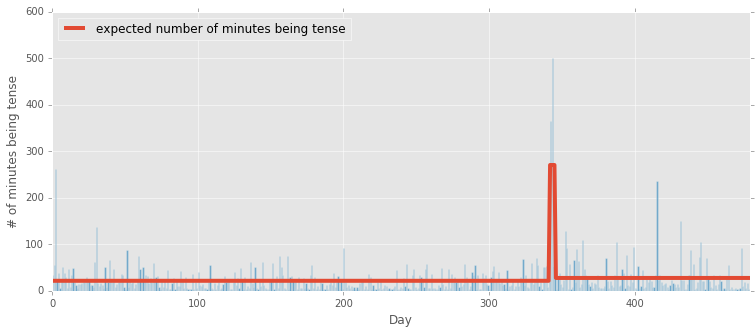

In [215]:
figsize(12.5, 5)
# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau1_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data3)
for day in range(0, n_count_data3):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau1_samples   
    iix = tau1_samples <= day 
    tmp = day < tau2_samples
    for i in range(len(iix)):
        if not tmp[i]:
            iix[i] = False
    iiix = tau2_samples <= day
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[iix].sum() + lambda_3_samples[iiix].sum()) / N


plt.plot(range(n_count_data3), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of minutes being tense")
plt.xlim(0, n_count_data3)
plt.xlabel("Day")
plt.ylabel("# of minutes being tense")
#plt.title("Expected number of minutes being calm")
plt.ylim(0, 600)
plt.bar(np.arange(len(count_data3)), count_data3, color="#348ABD", alpha=0.65)

plt.legend(loc="upper left");

**The shift point of user5 is about day 354!!**